+ 작성자: 최현승
+ 최종 작성일: 2018-03-26
+ 작성내용:Data Analytics
    1. Data Preprocessing
    2. Data Analytics
        + 2.1 Autoencoder
        + 2.2 Stacked Autoencoder
+ 데이터: 
    + train,test data set으로 구분된 NSL-KDD(전처리됨)
        + 입력데이터: 수치형데이터 + binary 데이터 + 카테고리 데이터
        + data/df_train = 전체데이터의 85%를 정상/비정상 90:10 비중으로 조절 
        + data/df_test = 전체데이터의 15%
        + 원본: NSL-KDD http://www.unb.ca/cic/datasets/nsl.html

In [1]:
model_name ='SAE_Train3'

In [2]:
import pandas as pd
import numpy as np
import sys
import tensorflow as tf

# 1. Data Preprocessing

In [3]:
# Data Import 
df_train = pd.read_csv('data/df_train3(preprocessed).csv')
df_test = pd.read_csv('data/df_test(preprocessed).csv')

In [4]:
# 수치형 변수 리스트
numeric_fields = ['duration', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']

# 부울형 변수 리스트 
binary_fields = ['land', 'logged_in', 'is_host_login','is_guest_login']

# 카테고리형 변수 리스트
category_fields = ['protocol_type1', 'protocol_type2', 'protocol_type3',
                   'service1', 'service2', 'service3', 'service4', 'service5',
                   'service6', 'service7', 'service8', 'service9', 'service10',
                   'service11', 'service12', 'service13', 'service14', 'service15',
                   'service16', 'service17', 'service18', 'service19', 'service20',
                   'service21', 'service22', 'service23', 'service24', 'service25',
                   'service26', 'service27',
                   'flag1', 'flag2', 'flag3', 'flag4', 'flag5',
                   'flag6', 'flag7', 'flag8', 'flag9']

total_fields = numeric_fields + binary_fields + category_fields

# numpy.array로 변환 
X_train = np.array(df_train[total_fields])

X_train_inputs, X_train_labels = \
                            np.array(df_train[total_fields]), np.array(df_train['attack_type'])
    
X_test_inputs, X_test_labels = \
                            np.array(df_test[total_fields]), np.array(df_test['attack_type'])
X_test_total = np.append(X_test_inputs, X_test_labels.reshape(-1,1), axis=1)  

# 2. Data Analyatics

In [5]:
from analytics_module import * 
import pickle

## 2.2.2 Stacked Autoencoder(2 Phased)

In [6]:
n_inputs = X_train.shape[1]
n_hidden1 = 32
n_hidden2 = 16  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.0001
l2_reg = 0.01


activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1
    
saver = tf.train.Saver(max_to_keep=1000)

phase1_errors = []
phase2_errors = []

training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [11, 11]
batch_sizes = [256, 256]
num_examples = X_train.shape[0]


init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)    

In [ ]:

for phase in range(2):
    print("Training phase #{}".format(phase + 1))
    for epoch in range(n_epochs[phase]):
        n_batches = num_examples // batch_sizes[phase]
        for iteration in range(n_batches):
            #print("\r{}%".format(100 * iteration // n_batches), end="")
            #sys.stdout.flush()
            X_batch = next_batch(batch_sizes[phase], X_train)
            sess.run(training_ops[phase], feed_dict={X: X_batch})
        loss_train = reconstruction_losses[phase].eval(session=sess,feed_dict={X: X_batch})
        if(phase + 1 == 1):
            phase1_errors.append(loss_train)
        if(phase + 1 == 2):
            phase2_errors.append(loss_train)    
        if epoch % 10 == 0: 
            print("\r{}".format(epoch), "Train MSE:", loss_train)  
            
# model save     
model_save_dir = './my_test_model/' + model_name+ '/l2_reg'+ str(l2_reg)+ '/learing_rate' + str(learning_rate) + '/epoch' + str(epoch)
print("model save : ",model_save_dir)
saver.save(sess, model_save_dir)            

# cost list save
cost_dir = './cost_list/' + model_name+ '/l2_reg'+ str(l2_reg) + '/learning_rate' + str(learning_rate) + '_epoch' + str(epoch) 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(phase1_errors, label='phase1_error')
plt.plot(phase2_errors, label='phase2_error')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Stacked Autoencoder Test(2-Phased)

In [7]:
# model restore
#learning_rate = 0.005
#le_reg  0.0001
epoch = 10

model_save_dir = './my_test_model/' + model_name+ '/l2_reg'+ str(l2_reg)+ '/learing_rate' + str(learning_rate) + '/epoch' + str(epoch)
saver.restore(sess, model_save_dir)

INFO:tensorflow:Restoring parameters from ./my_test_model/SAE_Train3/l2_reg0.01/learing_rate0.0001/epoch10


In [8]:
# Reconstruction Error Threshold 계산
input_data = X_train_inputs
output_data = sess.run(outputs, feed_dict={X: input_data})
total_data = X_train

df_performance = get_df_performance(input_data=input_data, output_data=output_data, total_data=total_data)

train_error = df_performance['error']
mu, sigma = error_statistics_check(train_error)

# 1%: mu + 2.33 * sigma
# 5%: mu + 1.645 * sigma
# 10%: mu + 1.28 * sigma 

threshold_1 = mu + (2.33 * sigma)
threshold_5 = mu + (1.645 * sigma)
threshold_10 = mu + (1.28 * sigma)
threshold_50 = mu

print("threshold_1=%f, threshold_5=%f, threshold_10=%f, threshold_50=%f"%(threshold_1, threshold_5, threshold_10, threshold_50))

# Test dataset으로 검증 
input_data = X_test_inputs
output_data = sess.run(outputs, feed_dict={X: input_data})
total_data = X_test_total

df_performance = get_df_performance(input_data=input_data, output_data=output_data, total_data=total_data)
performance_check(threshold = threshold_10, df = df_performance)

mu=1.553294, sigma=0.422317
threshold_1=2.537292, threshold_5=2.248005, threshold_10=2.093859, threshold_50=1.553294
tn:11021.00000, fp:588.00000, fn:1556.00000, tp:9113.00000, total:.22278.000000
accuracy: 0.90376, f1_score: 0.89475
sensitivity : 0.85416, specificity : 0.94935
precision : 0.93939, recall : 0.85416


# Visualization

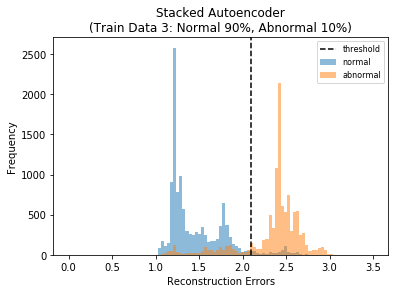

In [9]:
import numpy
import matplotlib.pyplot as plt
# test 
normal_error = df_performance[df_performance['attack_types'] == 'normal']['error']
abnormal_error = df_performance[df_performance['attack_types'] == 'abnormal']['error']

fig = plt.figure()
bins = numpy.linspace(0, 3.5, 100)

plt.title('Stacked Autoencoder\n(Train Data 3: Normal 90%, Abnormal 10%)')
plt.xlabel('Reconstruction Errors')
plt.ylabel('Frequency')
plt.axvline(x=threshold_10, color='black', linestyle='dashed', label='threshold')
plt.hist(normal_error, bins, alpha=0.5, label='normal')
plt.hist(abnormal_error, bins, alpha=0.5, label='abnormal')
plt.legend(loc='upper right', prop={'size': 8})
plt.show()
fig.savefig(model_save_dir+'.png')